# Rank by target development level and SLI

Post process machine learning predictions by dark kinase and SLI information.

The purpose of the current notebook is to prioritize these predictions by using prediction 
synthetic lethality interactions (SLIs) and to filter them according to  their status as 
1. Tclin -- proteins targeted by approved drugs with known mechanism of action.
2. Tchem -- proteins targeted by small molecules/drugs in ChEMBL or DrugCentral 
3. Tbio -- proteins that do not have known above-threshold drug or small molecule activities and are above the cutoff for Tdark and are annotated with a Gene Ontology Molecular Function or Biological Process leaf term(s) with an Experimental Evidence code
4. Tdark -- proteins about which virtually nothing is known. 

### Setup
This notebook depends on the files ``embedding_skipgram_dim100.npy``, ``words_before2021_jan3.txt``, 
``KCET_positive_2021.tsv``, and ``KCET_prediction_2021.tsv``. For now, Vida has made the files available in
Google drive. Download that folder to someplace on your drive, and then cd to the KCET/notebooks folder,
and softlist the downloaded folder
```
ln -s /path/to/downloaded/folder/ data
```
This notebook assumes it will find the files there.

We also need to copy the files ``SL_data.tsv`` to this directory. This file contains our gold-standard curated SLIs
and is generated in the [SLDBGen](https://github.com/monarch-initiative/SLDBGen) repository.
Finally, we need the file 'new_predicted_SLI_edges_from_positive_sli.csv', which is from the
[syntheticLethalityNetwork](https://github.com/monarch-initiative/syntheticLethalityNetwork/) repository.

In [1]:
import os
import sys
import csv
import pandas as pd
import numpy as np
from collections import defaultdict
sys.path.insert(0, os.path.abspath('..'))
from kcet import KcetParser

# Gold standard
The following links between protein kinase inhibitors and kinases were derived from 
[DrugCentral](https://drugcentral.org/) and manual curation. We will filter out results related to these
kinases with the motivation that they are already relatively well known.

In [2]:
kcet_parser = KcetParser()
gold_df = kcet_parser.get_gold_standard_df()
gold_df

,gene,protein kinase inhibitors
0,ABL1,"axitinib, bosutinib, dasatinib, imatinib, nilo..."
1,ALK,"alectinib, brigatinib, ceritinib, crizotinib, ..."
2,AXL,cabozantinib
3,BRAF,"dabrafenib, encorafenib, regorafenib, sorafeni..."
4,BTK,"acalabrutinib, ibrutinib, zanubrutinib"
5,CDK4,"abemaciclib, palbociclib, ribociclib"
6,CDK6,"abemaciclib, palbociclib, ribociclib"
7,CSF1R,pexidartinib
8,DDR2,actinomycin D
9,EGFR,"afatinib, cetuximab, dacomitinib, erlotinib, g..."


In [3]:
gold_set = set(gold_df['gene'])

## Predictions derived from PubMed embeddings
We have generated predictions that relate protein kinases to cancers in notebooks such as ``RandomForestPredictions``.

## Random forest predictions
From the ``RandomForestPredictions`` notebook.

In [4]:
predictions = pd.read_csv("predictions_2021.tsv",sep="\t")

In [5]:
predictions.head()

,gene_symbol,cancer,probability
0,IGF1R,"Carcinoma, Hepatocellular",0.89
1,MET,Liver Neoplasms,0.89
2,IGF1R,Lung Neoplasms,0.87
3,ERBB3,"Carcinoma, Hepatocellular",0.87
4,ERBB3,Thyroid Neoplasms,0.85


## TDL categories
We retrieve a dataframe to display the data (``tld_df``). We then retrieve a map from the same data that related the gene symbol to the target level.

In [6]:
symbol_to_tdl_map = kcet_parser.get_symbol_to_tdl_map()

### Probability distribution of Tclin, Tchem, Tbio, and Tdark predictions
Here we plot the distributions of proteins in the four different TLD groups. Note that one protein will have multiple entries , one for each cancer.

In [7]:
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np

In [8]:
tclin_pred =[]
tbio_pred = []
tchem_pred = []
tdark_pred = []
identified_kinases = set()
tchem_kinases = set()
tclin_kinases = set()
tbio_kinases = set()
tdark_kinases = set()
for _, row in predictions.iterrows():
    sym = row['gene_symbol']
    pr = float(row['probability'])
    tld = symbol_to_tdl_map.get(sym, 'na')
    if tld == 'na':
        continue # Note -- our predictions contain more than kinases, 
        # We do not expect to find every symbol in this map
    else:
        identified_kinases.add(sym)
    if tld == 'Tchem':
        tchem_pred.append(pr)
        tchem_kinases.add(sym)
    elif tld == 'Tbio':
        tbio_pred.append(pr)
        tbio_kinases.add(sym)
    elif tld == 'Tclin':
        tclin_pred.append(pr)
        tclin_kinases.add(sym)
    elif tld == 'Tdark':
        tdark_pred.append(pr)
        tdark_kinases.add(sym)
    else:
        raise ValueError("Unrecognized category:", tld)
print("[INFO] Found values for %d kinases" % len(identified_kinases))

print("[INFO] Tclin kinases:%d kinases" % len(tclin_kinases))
print("[INFO] Tchem kinases %d kinases" % len(tchem_kinases))
print("[INFO] Tbio %d kinases" % len(tbio_kinases))
print("[INFO] Tdark %d kinases" % len(tdark_kinases))

[INFO] Found values for 470 kinases
[INFO] Tclin kinases:61 kinases
[INFO] Tchem kinases 329 kinases
[INFO] Tbio 70 kinases
[INFO] Tdark 10 kinases


Text(0.5, 1.0, 'Protein kinases according to TDL')

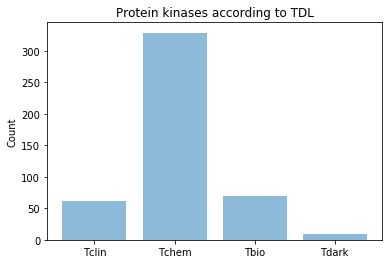

In [9]:
objects = ('Tclin', 'Tchem', 'Tbio', 'Tdark')
y_pos = np.arange(len(objects))
performance = [len(tclin_kinases),len(tchem_kinases),len(tbio_kinases),len(tdark_kinases)]

plt.bar(y_pos, performance, align='center', alpha=0.5)
plt.xticks(y_pos, objects)
plt.ylabel('Count')
plt.title('Protein kinases according to TDL')

In [10]:
data1 = np.array(tclin_pred)
data2 = np.array(tchem_pred)
data3 = np.array(tbio_pred)
data4 = np.array(tdark_pred)
print("Tclin predictions n=%d" % len(data1))
print("Tchem predictions n=%d" % len(data2))
print("Tbio predictions n=%d" % len(data3))
print("Tdark predictions n=%d" % len(data4))

Tclin predictions n=35601
Tchem predictions n=218524
Tbio predictions n=46550
Tdark predictions n=6650


Text(0.5, 1.0, 'Predictions according to TDL')

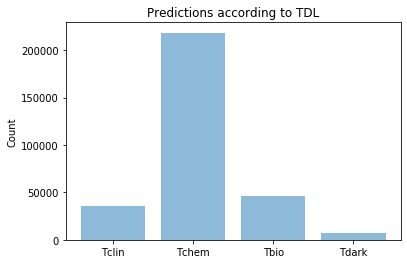

In [11]:
objects = ('Tclin', 'Tchem', 'Tbio', 'Tdark')
y_pos = np.arange(len(objects))
performance = [len(tclin_pred),len(tchem_pred),len(tbio_pred),len(tdark_pred)]

plt.bar(y_pos, performance, align='center', alpha=0.5)
plt.xticks(y_pos, objects)
plt.ylabel('Count')
plt.title('Predictions according to TDL')

Note that we expect the proportions of predictions to be equal to the number of genes in each category, this figure is just a sanity check. The following checks the distribution of our gold standard genes according to category. We see that some genes with clinical approval are still in Tchem.

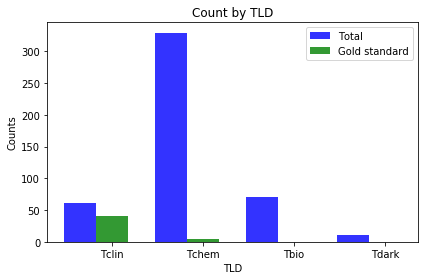

In [12]:
# data to plot
n_groups = 4

n_gold_tclin = sum([1 for x in tclin_kinases if x in gold_set]) 
n_gold_tchem = sum([1 for x in tchem_kinases if x in gold_set]) 
n_gold_tbio = sum([1 for x in tbio_kinases if x in gold_set]) 
n_gold_tdark = sum([1 for x in tdark_kinases if x in gold_set]) 
means_total = (len(tclin_kinases),len(tchem_kinases),len(tbio_kinases),len(tdark_kinases))
means_gold_overlap = (n_gold_tclin, n_gold_tchem, n_gold_tbio, n_gold_tdark)

# create plot
fig, ax = plt.subplots()
index = np.arange(n_groups)
bar_width = 0.35
opacity = 0.8

rects1 = plt.bar(index, means_total, bar_width,
alpha=opacity,
color='b',
label='Total')

rects2 = plt.bar(index + bar_width, means_gold_overlap, bar_width,
alpha=opacity,
color='g',
label='Gold standard')

plt.xlabel('TLD')
plt.ylabel('Counts')
plt.title('Count by TLD')
plt.xticks(index + bar_width, ('Tclin', 'Tchem', 'Tbio', 'Tdark'))
plt.legend()

plt.tight_layout()

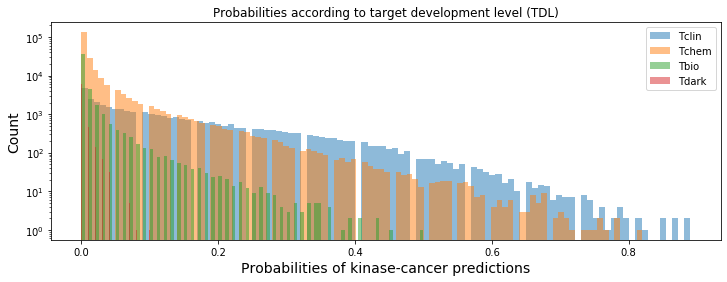

In [13]:
plt.figure(figsize=(12,4))
plt.hist(data1, bins=100, alpha=0.5, label="Tclin", log=True)
plt.hist(data2, bins=100, alpha=0.5, label="Tchem", log=True)
plt.hist(data3, bins=100, alpha=0.5, label="Tbio", log=True)
plt.hist(data4, bins=100, alpha=0.5, label="Tdark", log=True)
plt.xlabel("Probabilities of kinase-cancer predictions", size=14)
plt.ylabel("Count", size=14)
plt.title("Probabilities according to target development level (TDL)")
plt.legend(loc='upper right')

We see that the probabilities in the Tclin class include the highest values. This is expected, because this group includes our positive
set. Also, the fact that there are low probabilities in the Tclin group is expected, because not every combination of
a protein kinase and cancer is relevant. However, the fact that there are different distributions in the four groups
is to be expected.
The probability distributions of the positive and negative sets were plotted in the ``RandomForestPredictions`` notebook.

# Import the SLI predictions

In [15]:
data_directory = 'data'
if not os.path.isdir(data_directory):
    raise FileNotFoundError("Could not find data directory")

In [16]:
predicted_sli = os.path.join(data_directory,'new_predicted_SLI_edges_from_positive_sli.csv')
if not os.path.exists(predicted_sli):
    raise FileNotFoundError("Could not find predicted SLI file")

The following is a simple class to store information about a synthetic lethal interaction.

In [17]:
class SLI:
    def __init__(self, s:str, d:str, score:float=1.0):
        """
        s and d -- gene symbols, source and destination
        score -- prediction. If no score is provided, we assume this is a positive example 
        and give a score of 1.0
        """
        self._geneA = s
        self._geneB = d
        self._score = score
    
    @property
    def geneA(self):
        return self._geneA
    
    @property
    def geneB(self):
        return self._geneB
    
    @property
    def score(self):
        return self._score
    
    def get_other_gene(self, gene):
        if gene == self._geneA and gene != self._geneB:
            return self._geneB
        elif gene == self._geneB and gene != self._geneA:
            return self._geneA
        else:
            # should never happen
            raise ValueError("get_other_gene could not find %s" % gene)

In [18]:
gene_to_sli_dict = defaultdict(list)
pred_probs = []
with open(predicted_sli) as f:
    reader = csv.DictReader(f)
    for row in reader:
        score = float(row['score'])
        sli = SLI(s=row['sources'], d=row['destinations'], score=score)
        gene_to_sli_dict[sli.geneA].append(sli)
        gene_to_sli_dict[sli.geneB].append(sli)
        pred_probs.append(score)   

In [19]:
print("[INFO] We extracted information for %d genes" % len(gene_to_sli_dict))
print("[INFO] We extracted probabilities for a total of %d predictions " % len(pred_probs))

[INFO] We extracted information for 1740 genes
[INFO] We extracted probabilities for a total of 1510542 predictions 


# Plot the distribution of SLI predictions

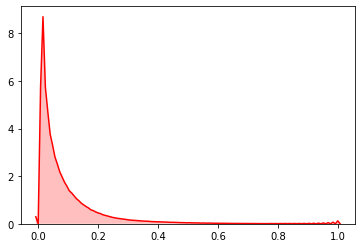

In [20]:
import matplotlib.pyplot as plt
%matplotlib inline  
import seaborn as sns
preddata = np.array(pred_probs)
p1=sns.kdeplot(data=preddata, shade=True, color="r")

In [21]:
print("Minimum probability:", np.min(preddata))
print("Maximum probability:", np.max(preddata))
print("prob at 99th percentile:", np.percentile(preddata, 99))
print("prob at 98th percentile:", np.percentile(preddata, 98))
print("prob at 95th percentile:", np.percentile(preddata, 95))
print("prob at 90th percentile:", np.percentile(preddata, 90))
print("prob at 80th percentile:", np.percentile(preddata, 80))

Minimum probability: 2.6390735640757572e-05
Maximum probability: 0.9996010995048986
prob at 99th percentile: 0.45920420218211316
prob at 98th percentile: 0.3419636110736219
prob at 95th percentile: 0.20999053260163547
prob at 90th percentile: 0.13398528275623633
prob at 80th percentile: 0.06877193635353454


# Gold standard SLI data

In [22]:
gold_standard_sli = os.path.join(data_directory,'SL_data.tsv')
if not os.path.exists(gold_standard_sli):
    raise FileNotFoundError("Could not find gold_standard_sli file")

In [23]:
gold_sli_dict = defaultdict(list)
with open(gold_standard_sli) as f:
    reader = csv.DictReader(f, delimiter='\t')
    for row in reader:
        if row['SL'] != 'T':
            continue
        geneA = row['geneA']
        geneB = row['geneB']
        sli = SLI(s=geneA, d=geneB) # score will default to 1.0
        gold_sli_dict[sli.geneA].append(sli)
        gold_sli_dict[sli.geneB].append(sli)
print("[INFO] We extracted gold standard data for %d genes" % len(gold_sli_dict))

[INFO] We extracted gold standard data for 1747 genes


# Display kinases and corresponding SLI data
Following the analysis of probabilities in the ``RandomForestPredictions`` notebook, we will retain predictions with a probability above 0.39 and which are kinases. We will divide the predictions into four groups.

In [24]:
THRESHOLD = 0.39
SLI_THRESHOLD = np.percentile(preddata, 95) # top 5% of the predictions
c = 0
gold_standard = kcet_parser.get_gold_standard_set() # kinases with clinical indications
prediction_dict = defaultdict(list)
for _, row in predictions.iterrows():
    pr = float(row['probability'])
    if pr < THRESHOLD:
        continue
    else:
        c += 1
    gene = row['gene_symbol']
    if not gene in symbol_to_tdl_map:
        continue
    tdl = symbol_to_tdl_map.get(gene)
    cancer = row['cancer']
    if gene in gene_to_sli_dict:
        predicted_sli_list = gene_to_sli_dict.get(gene)
        for sl in predicted_sli_list:
            if sl.score < SLI_THRESHOLD:
                continue
            othergene = sl.get_other_gene(gene)
            sli_prob = sl.score
            total_prob = sli_prob * pr
            gold = "-"
            if gene in gold_standard:
                gold = 'gold'
            d = {'cancer':cancer, 'gene': gene, 'pubmed-prob': pr, 'sl-gene': othergene, 'sl-prob': sl.score, 'sl-method':'predicted', 'combined-score': total_prob, 'standard': gold}
            prediction_dict[tdl].append(d)
    else:
        d = {'cancer':cancer, 'gene': gene, 'pubmed-prob': pr, 'sl-gene': 'none', 'sl-prob': 0.0, 'sl-method':'none-found', 'combined-score': 0.5*pr, 'standard': gold}
        prediction_dict[tdl].append(d)
    if gene in gold_sli_dict:
        gold_sli_list = gold_sli_dict.get(gene)
        for sl in gold_sli_list:
            if sl.score < SLI_THRESHOLD:
                continue
            othergene = sl.get_other_gene(gene)
            d = {'cancer':cancer, 'gene': gene, 'pubmed-prob': pr, 'sl-gene': othergene, 'sl-prob': sl.score, 'sl-method':'gold-standard', 'combined-score':pr, 'standard': gold}
            prediction_dict[tdl].append(d)
print("Total retained PubMed predictions ", c)

Total retained PubMed predictions  3216


## Tclin
These kinases are the best known.

In [25]:
tclin_df = pd.DataFrame(prediction_dict.get('Tclin'))

In [26]:
tclin_df.head()

,cancer,combined-score,gene,pubmed-prob,sl-gene,sl-method,sl-prob,standard
0,"Carcinoma, Hepatocellular",0.658015,IGF1R,0.89,MYC,predicted,0.739342,gold
1,"Carcinoma, Hepatocellular",0.651476,IGF1R,0.89,VHL,predicted,0.731995,gold
2,"Carcinoma, Hepatocellular",0.596067,IGF1R,0.89,ATR,predicted,0.669738,gold
3,"Carcinoma, Hepatocellular",0.589935,IGF1R,0.89,RB1,predicted,0.662848,gold
4,"Carcinoma, Hepatocellular",0.572373,IGF1R,0.89,KRAS,predicted,0.643115,gold


In [27]:
print("[INFO] Total of %d predictions for Tclin" % len(tclin_df))

[INFO] Total of 865850 predictions for Tclin


# Sort by combined score

In [28]:
tclin_df = tclin_df.sort_values('combined-score', ascending=False)
tclin_df.head(50)

,cancer,combined-score,gene,pubmed-prob,sl-gene,sl-method,sl-prob,standard
2168,Liver Neoplasms,0.89,MET,0.89,VHL,gold-standard,1.0,gold
2196,Liver Neoplasms,0.89,MET,0.89,HSPB1,gold-standard,1.0,gold
2189,Liver Neoplasms,0.89,MET,0.89,AREG,gold-standard,1.0,gold
2190,Liver Neoplasms,0.89,MET,0.89,INSRR,gold-standard,1.0,gold
2191,Liver Neoplasms,0.89,MET,0.89,CCND2,gold-standard,1.0,gold
2192,Liver Neoplasms,0.89,MET,0.89,CHRNA7,gold-standard,1.0,gold
2193,Liver Neoplasms,0.89,MET,0.89,CD151,gold-standard,1.0,gold
2194,Liver Neoplasms,0.89,MET,0.89,CDKN2C,gold-standard,1.0,gold
2195,Liver Neoplasms,0.89,MET,0.89,EGFR,gold-standard,1.0,gold
500,"Carcinoma, Hepatocellular",0.89,IGF1R,0.89,CHEK1,gold-standard,1.0,gold


# Tchem

In [29]:
tchem_df = pd.DataFrame(prediction_dict.get('Tchem'))
tchem_df.head()

,cancer,combined-score,gene,pubmed-prob,sl-gene,sl-method,sl-prob,standard
0,"Carcinoma, Hepatocellular",0.410000,TGFBR2,0.82,none,none-found,0.000000,gold
1,Leukemia,0.456684,AKT1,0.78,TP53,predicted,0.585492,-
2,Leukemia,0.455312,AKT1,0.78,CHEK2,predicted,0.583734,-
3,Leukemia,0.431810,AKT1,0.78,CLSPN,predicted,0.553603,-
4,Leukemia,0.430754,AKT1,0.78,VHL,predicted,0.552249,-


In [30]:
print("[INFO] Total of %d predictions for Tchem" % len(tchem_df))

[INFO] Total of 153100 predictions for Tchem


In [31]:
tchem_df = tchem_df.sort_values('combined-score', ascending=False)
tchem_df.head(50)

,cancer,combined-score,gene,pubmed-prob,sl-gene,sl-method,sl-prob,standard
832,Leukemia,0.78,AKT1,0.78,CHML,gold-standard,1.0,-
838,Leukemia,0.78,AKT1,0.78,TXNRD1,gold-standard,1.0,-
831,Leukemia,0.78,AKT1,0.78,SLC9C1,gold-standard,1.0,-
969,"Lymphoma, Non-Hodgkin",0.78,MAP2K7,0.78,LCK,gold-standard,1.0,-
841,Leukemia,0.78,AKT1,0.78,CHEK1,gold-standard,1.0,-
840,Leukemia,0.78,AKT1,0.78,PRKDC,gold-standard,1.0,-
839,Leukemia,0.78,AKT1,0.78,AKT2,gold-standard,1.0,-
970,"Lymphoma, Non-Hodgkin",0.78,MAP2K7,0.78,MYC,gold-standard,1.0,-
837,Leukemia,0.78,AKT1,0.78,CTSD,gold-standard,1.0,-
836,Leukemia,0.78,AKT1,0.78,CFLAR,gold-standard,1.0,-


# Tbio

In [ ]:
tbio_df = pd.DataFrame(prediction_dict.get('Tbio'))
tbio_df.head()

In [ ]:
print("[INFO] Total of %d predictions for Tbio" % len(tbio_df))

In [ ]:
tbio_df = tbio_df.sort_values('combined-score', ascending=False)
tbio_df.head(50)

# Tdark

In [ ]:
tdark_df = pd.DataFrame(prediction_dict.get('Tdark'))
print("[INFO] Above-threshold Predictions for Tdark n=%d" % len(tdark_df))

Since there are no above threshold interactions for Tdark, let's get all Tdark predictions regardless of threshold

In [ ]:
dark_kinase_predictions = []
for _, row in predictions.iterrows():
    pr = float(row['probability'])
    gene = row['gene_symbol']
    if not gene in symbol_to_tdl_map:
        continue
    tdl = symbol_to_tdl_map.get(gene)
    if tdl != 'Tdark':
        continue
    cancer = row['cancer']
    if gene in gene_to_sli_dict:
        predicted_sli_list = gene_to_sli_dict.get(gene)
        for sl in predicted_sli_list:
            if sl.score < SLI_THRESHOLD:
                continue
            othergene = sl.get_other_gene(gene)
            sli_prob = sl.score
            total_prob = sli_prob * pr
            d = {'cancer':cancer, 'gene': gene, 'pubmed-prob': pr, 'sl-gene': othergene, 'sl-prob': sl.score, 'sl-method':'predicted', 'combined-score': total_prob}
            dark_kinase_predictions.append(d)
    else:
        d = {'cancer':cancer, 'gene': gene, 'pubmed-prob': pr, 'sl-gene': 'none', 'sl-prob': 0.0, 'sl-method':'none-found', 'combined-score': 0.5*pr}
        dark_kinase_predictions.append(d)
    if gene in gold_sli_dict:
        gold_sli_list = gold_sli_dict.get(gene)
        for sl in gold_sli_list:
            if sl.score < SLI_THRESHOLD:
                continue
            othergene = sl.get_other_gene(gene)
            d = {'cancer':cancer, 'gene': gene, 'pubmed-prob': pr, 'sl-gene': othergene, 'sl-prob': sl.score, 'sl-method':'gold-standard', 'combined-score':pr}
            dark_kinase_predictions.append(d)
print("Total retained PubMed dar kinase predictions ", len(dark_kinase_predictions))

In [ ]:
tdark_df = pd.DataFrame(dark_kinase_predictions)
tdark_df.head()

In [ ]:
tdark_df = tdark_df.sort_values('combined-score', ascending=False)
tdark_df.head(50)

# Output results to file

In [ ]:
outputAllResults = False
N_TRUNCATION = 2000 # output this number of predictions per category
if outputAllResults:
    tclin_df.to_csv('tclin_combined_predictions.tsv',sep='\t', index=False)
    tdark_df.to_csv('tdark_combined_predictions.tsv',sep='\t', index=False)
    tbio_df.to_csv('tbio_combined_predictions.tsv',sep='\t', index=False)
    tchem_df.to_csv('tchem_combined_predictions.tsv',sep='\t', index=False)
else:
    tclin_df.head(N_TRUNCATION).to_csv('tclin_combined_predictions.tsv',sep='\t', index=False)
    tdark_df.head(N_TRUNCATION).to_csv('tdark_combined_predictions.tsv',sep='\t', index=False)
    tbio_df.head(N_TRUNCATION).to_csv('tbio_combined_predictions.tsv',sep='\t', index=False)
    tchem_df.head(N_TRUNCATION).to_csv('tchem_combined_predictions.tsv',sep='\t', index=False)